In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])



In [2]:
basepath = Path("/scratch/crobin/earthnet2023_preprocessed/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(Path("/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023_preprocessed/").glob("test/*/*.nc")) #list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/Net/Groups/BGI/scratch/crobin/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_lr_1e-6/preds/iid/").glob("*/*"))
print("len train set: ", len(train_paths))
print("len test set: ", len(test_paths))
print("len prediction set: ", len(pred_paths))

len train set:  30499
len test set:  4114
len prediction set:  210


In [9]:
pred_path = pred_paths[12]
name = str(pred_path)[-12:]
test_path = list(Path("/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023_preprocessed/").glob("test/*/" + name))[0]
print(test_path)


/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023_preprocessed/test/Algeria/31SEU4605.nc


In [15]:
pred_path = "/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023/test/Algeria/31SEV5535.nc"
minicube = xr.open_dataset(pred_path)
print(minicube)

<xarray.Dataset>
Dimensions:               (time: 2191, lon: 128, lat: 128, time_clim: 12)
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-02 ... 2021-12-31
  * lon                   (lon) float64 3.778 3.778 3.778 ... 3.792 3.792 3.793
  * lat                   (lat) float64 35.74 35.74 35.74 ... 35.73 35.73 35.73
  * time_clim             (time_clim) datetime64[ns] 1970-01-15 ... 1970-12-15
Data variables: (12/72)
    s2_avail              (time) float32 ...
    s2_B02                (time, lat, lon) float32 ...
    s2_B03                (time, lat, lon) float32 ...
    s2_B04                (time, lat, lon) float32 ...
    s2_B05                (time, lat, lon) float32 ...
    s2_B06                (time, lat, lon) float32 ...
    ...                    ...
    sg_sand_top_mean      (lat, lon) float32 ...
    sg_sand_sub_mean      (lat, lon) float32 ...
    sg_silt_top_mean      (lat, lon) float32 ...
    sg_silt_sub_mean      (lat, lon) float32 ...
    sg_soc_t

RGB plots

/User/homes/crobin/miniconda3/envs/EarthnetEnv2/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


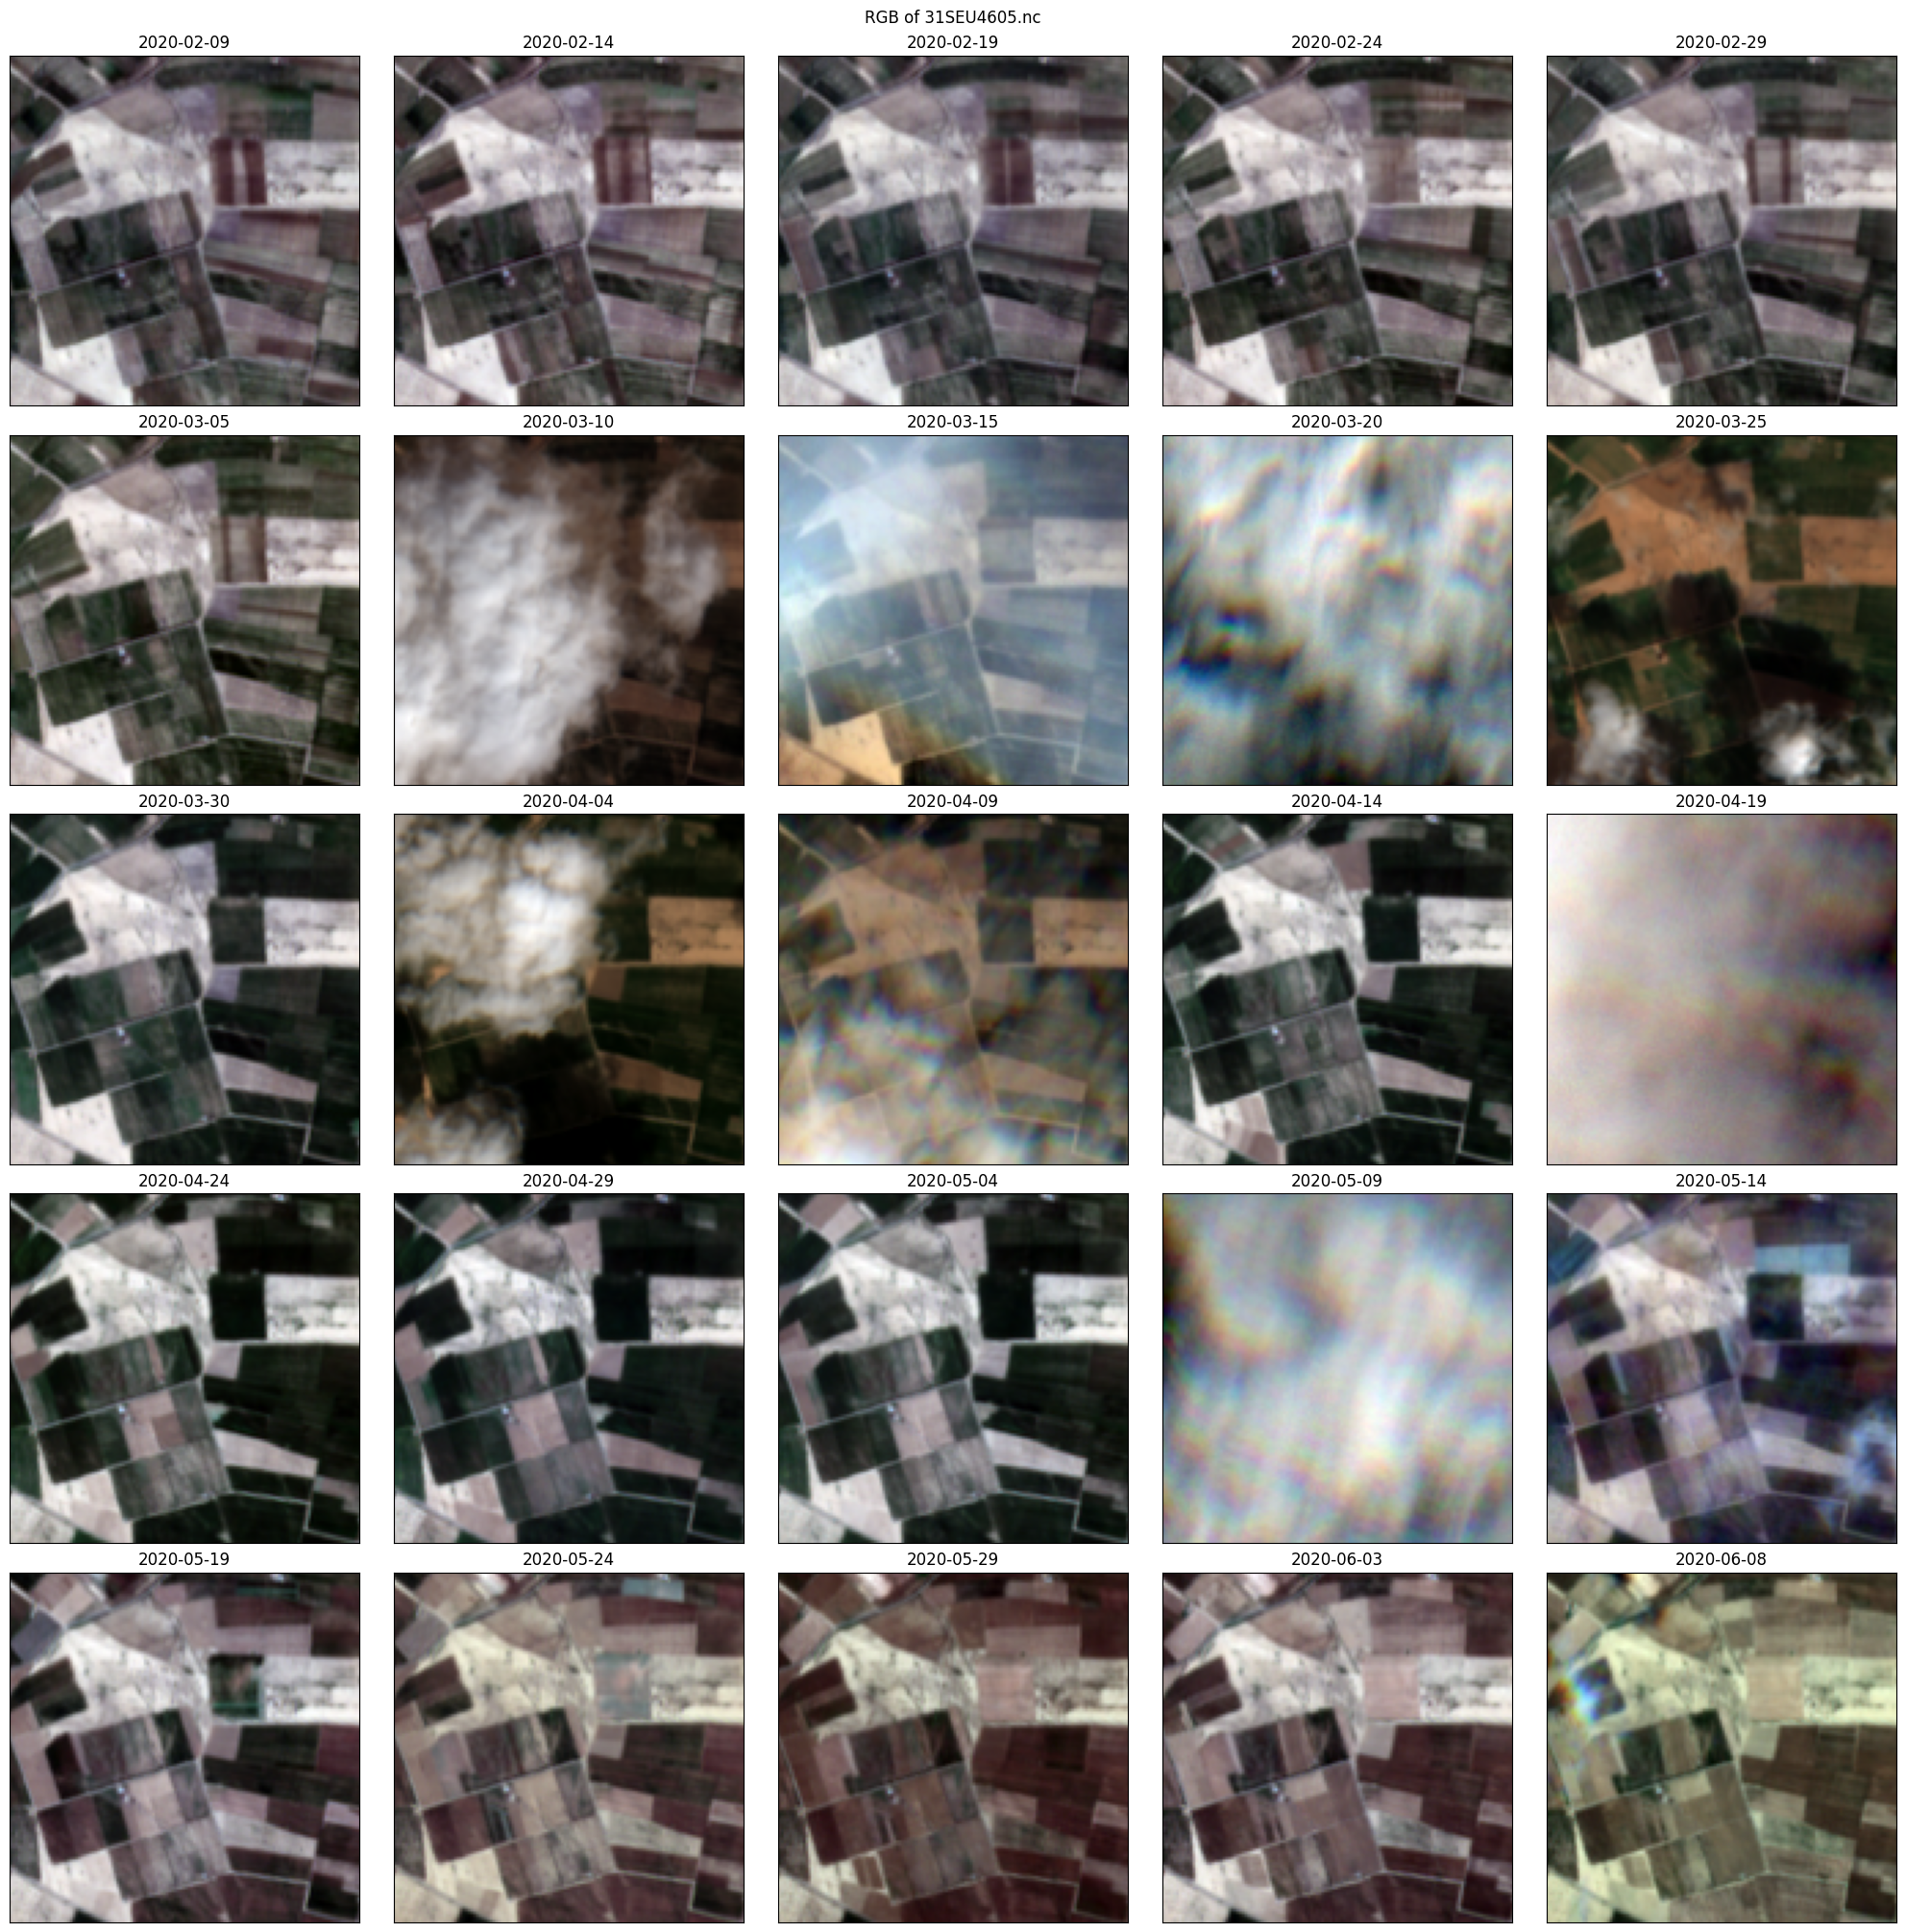

In [10]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def brighten(band):
    alpha=1
    beta=0
    return np.clip(alpha*band+beta, 0,255)

minicube = xr.open_dataset(test_path)
time = np.where(minicube.s2_avail.values == 1)[0]

fig, axes = plt.subplots(nrows=5, ncols=5, constrained_layout=True, figsize=(20, 20))
fig.suptitle("RGB of " + name)
t= 4
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=time[t]).time.dt.date.values)

        red = brighten(normalize(minicube.isel(time=time[t]).s2_B04))
        green = brighten(normalize(minicube.isel(time=time[t]).s2_B03))
        blue = brighten(normalize(minicube.isel(time=time[t]).s2_B02))

        rgb_composite= np.dstack((red, green, blue))
        axes[i,j].imshow(rgb_composite)
        t += 1


Mask

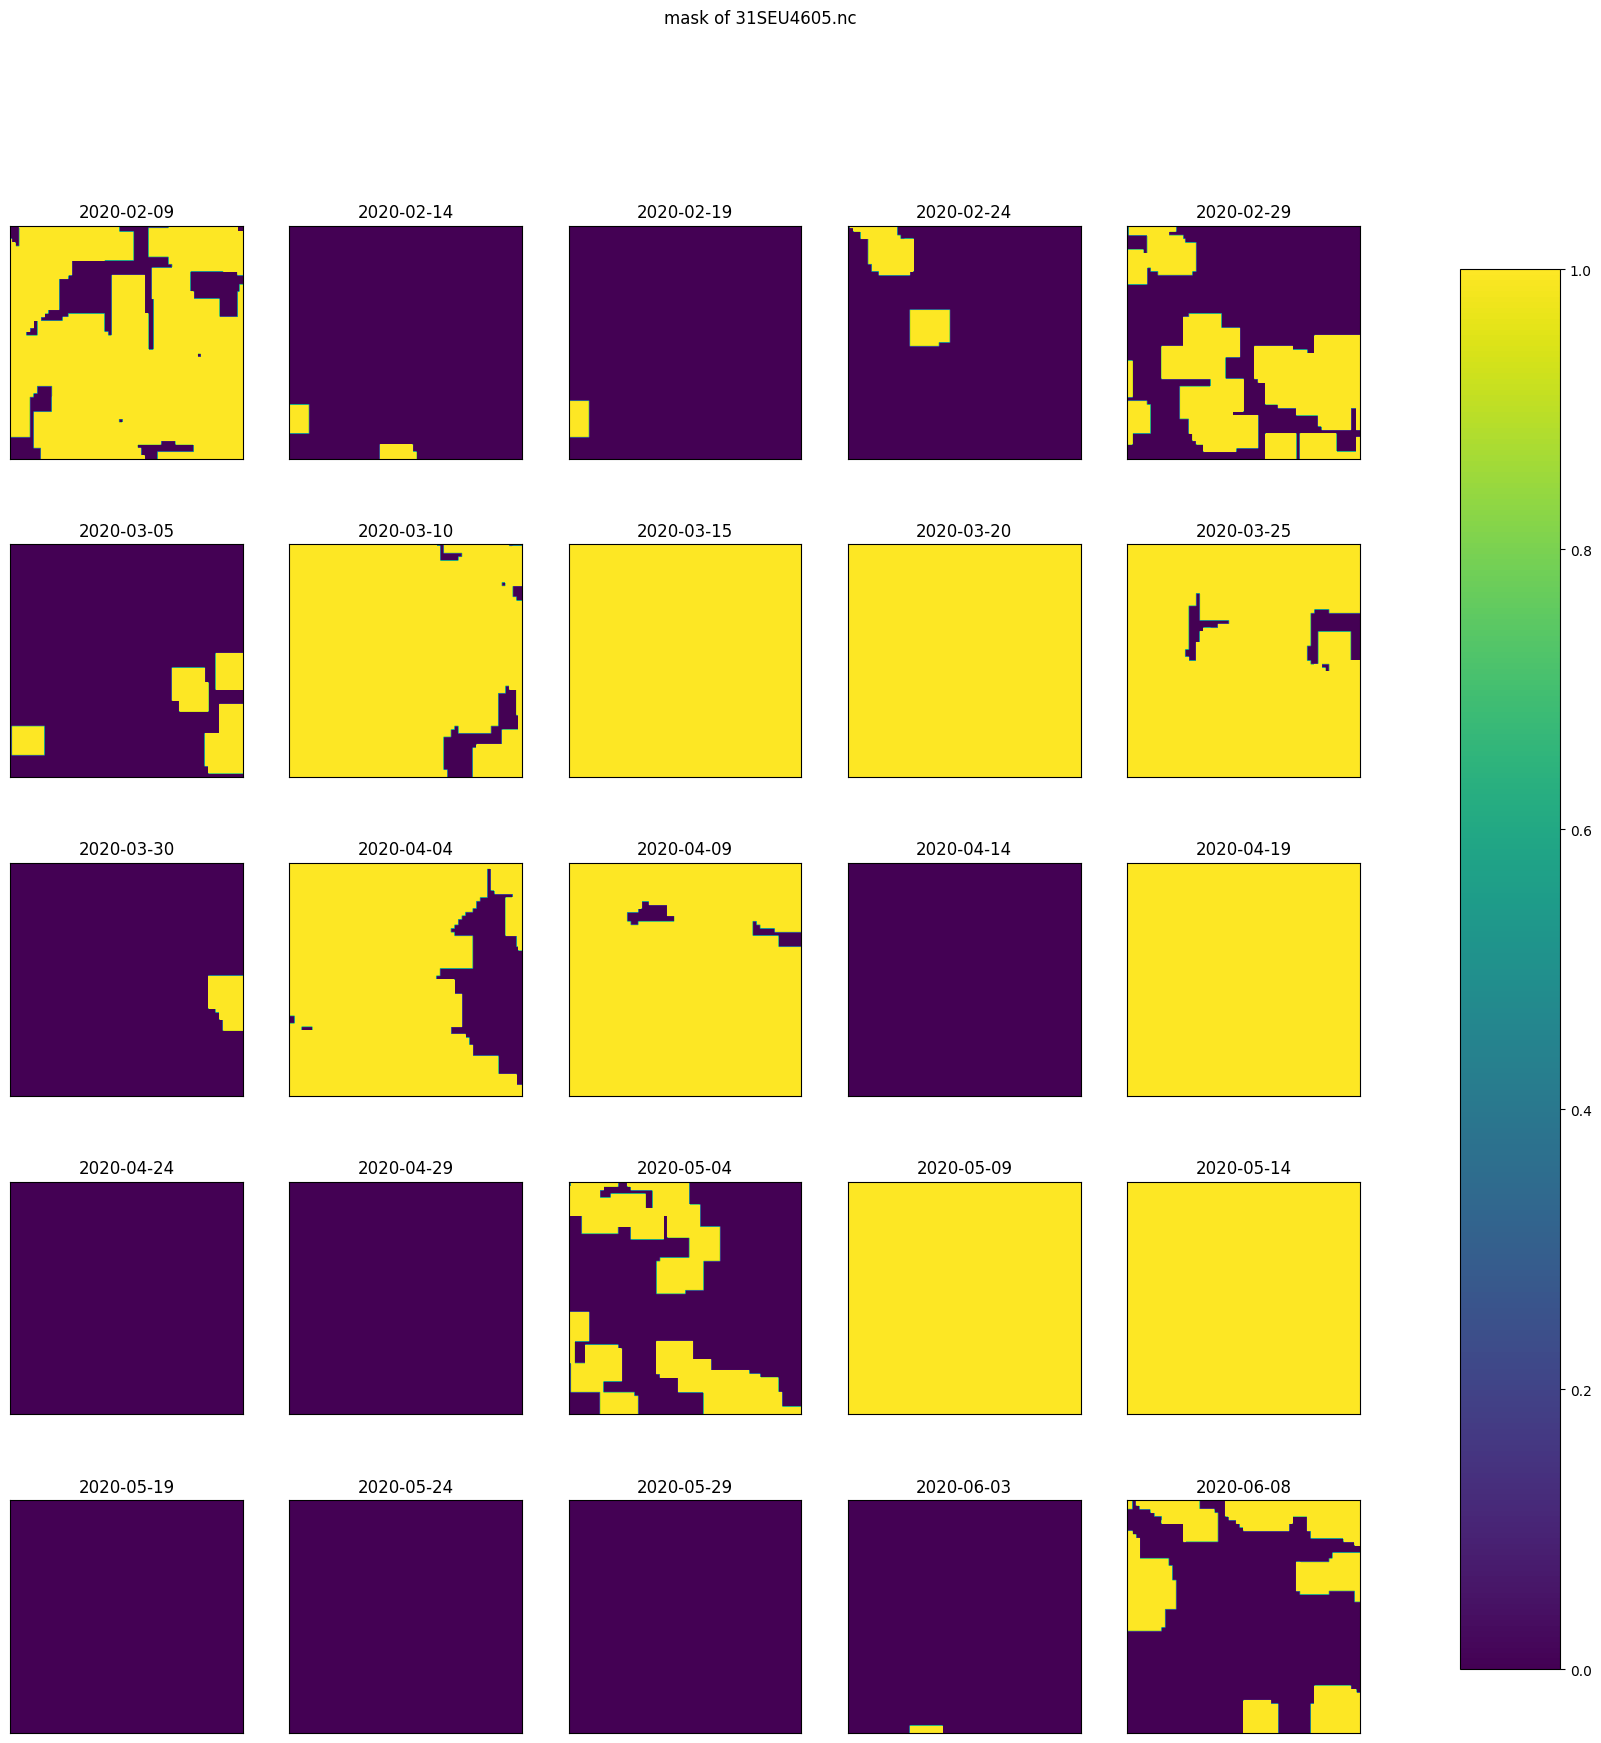

In [11]:
minicube = xr.open_dataset(test_path)
targ = minicube.s2_mask
cmap = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle("mask of " + name)
t= 4
for i in range(5):
    for j in range(5):
        #axes[i,j].set_aspect(1)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=time[t]).time.dt.date.values)
        im = axes[i,j].imshow(targ.isel(time=time[t]), vmin=0, vmax=1)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


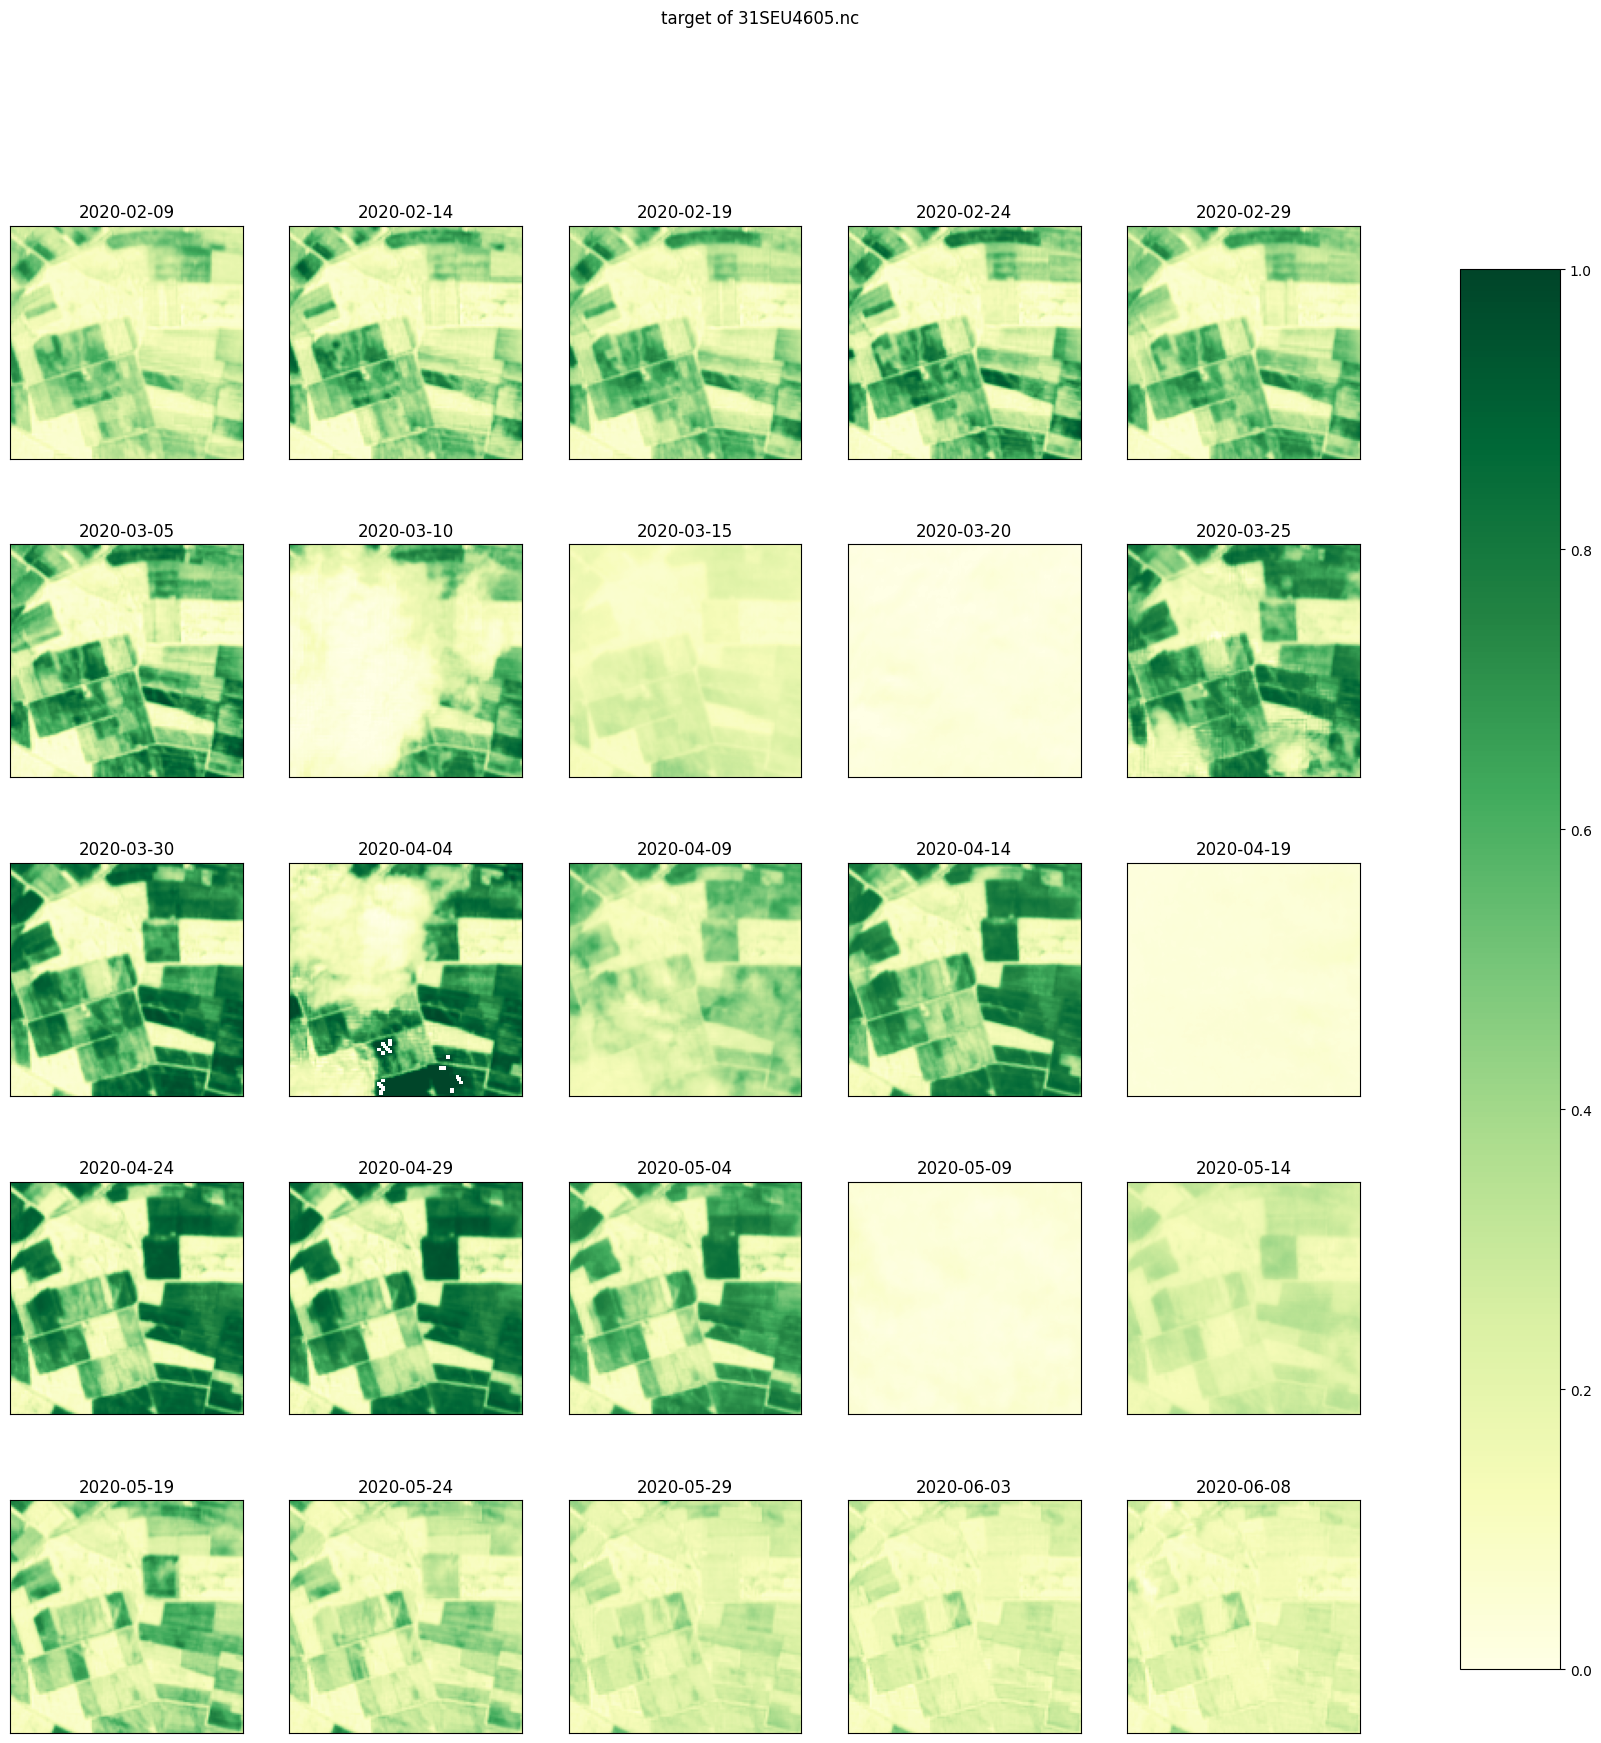

In [12]:
minicube = xr.open_dataset(test_path)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle("target of " + name)
t= 4
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=time[t]).time.dt.date.values)
        im = axes[i,j].imshow(targ.isel(time=time[t]), cmap=cmap_veg, vmin=0, vmax=1)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

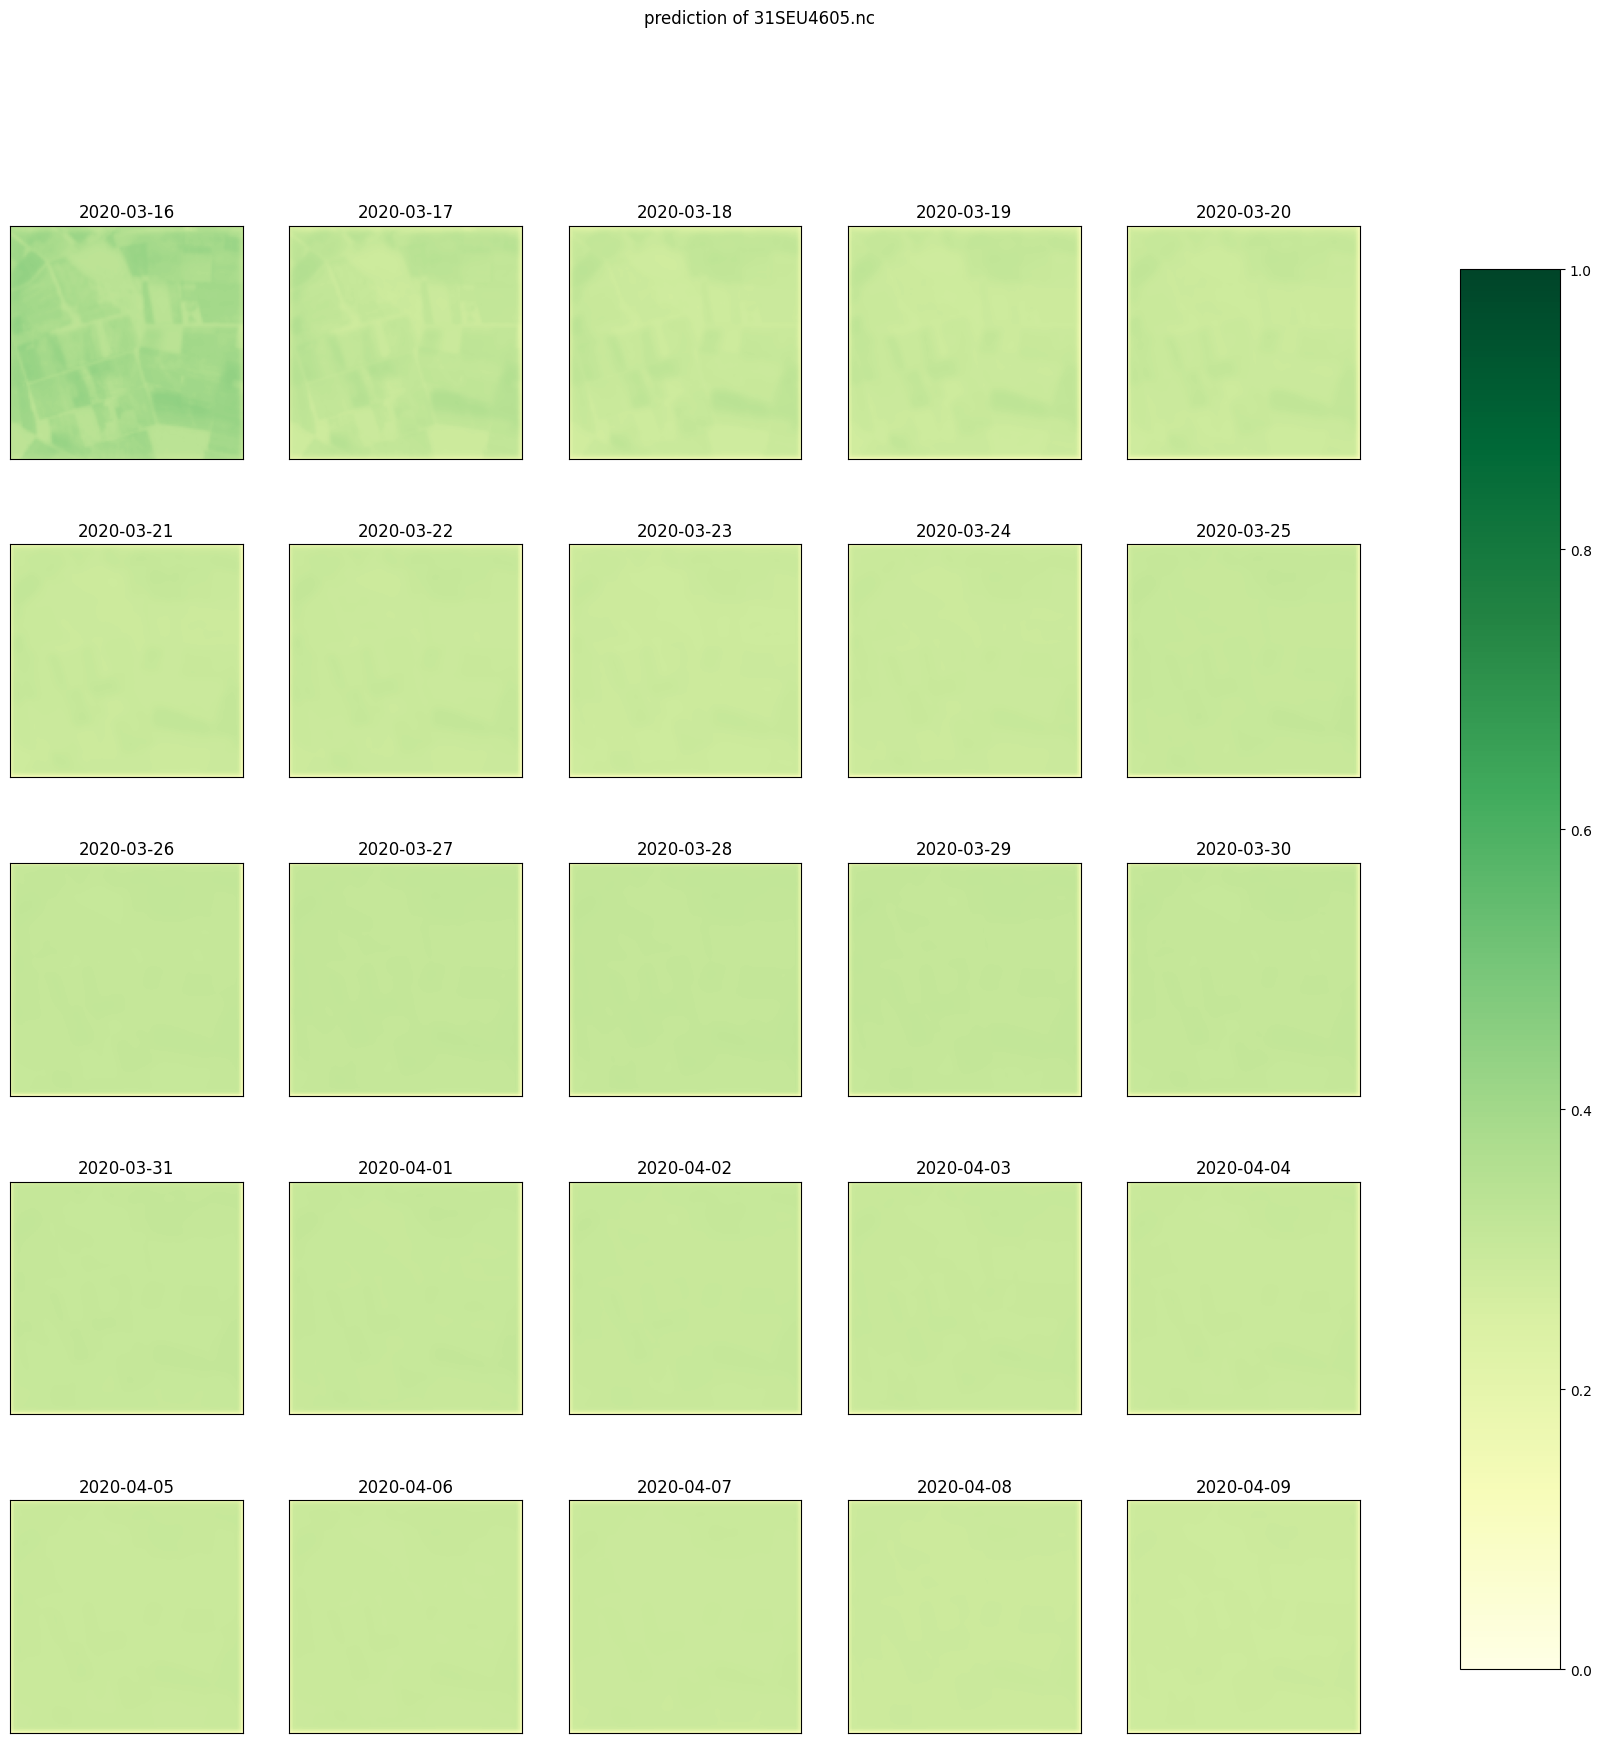

In [13]:
minicube = xr.open_dataset(pred_path)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle("prediction of " + name)
t= 0
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(minicube.isel(time=t).time.dt.date.values)
        im = axes[i,j].imshow(minicube.ndvi_pred.isel(time=t), cmap=cmap_veg, vmin=0, vmax=1)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [53]:
print(minicube)

<xarray.Dataset>
Dimensions:    (time: 30, latitude: 128, longitude: 128)
Coordinates:
  * time       (time) datetime64[ns] 2017-02-24 2017-03-01 ... 2017-07-19
  * latitude   (latitude) float64 -2.55 -2.55 -2.55 ... -2.561 -2.562 -2.562
  * longitude  (longitude) float64 33.58 33.58 33.58 33.58 ... 33.59 33.59 33.59
Data variables:
    ndvi_pred  (latitude, longitude, time) float32 ...


In [ ]:
for i in range(1, 13):
    indices = targ.groupby("time.month").groups[i]
    index_month = minicube.ndviclim_mean.groupby("time_clim.month").groups[
        i
    ]
    targ[indices] = (
        targ[indices].values - minicube.ndviclim_mean[index_month].values
    )

In [6]:
ndvi = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
print(minicube.era5_t2m.time.dt.month)

print(ndvi.shape, minicube.era5_t2m.shape)
print(minicube.era5_t2m.time.values)
print(minicube.era5_t2m.month)

targ = np.abs(ndvi - minicube.ndviclim_mean)
print(targ.shape)

(2191, 128, 128) (2191,)
<xarray.DataArray 'time' (time: 2191)>
array(['2016-01-02T00:00:00.000000000', '2016-01-03T00:00:00.000000000',
       '2016-01-04T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-02 2016-01-03 ... 2021-12-31


AttributeError: 'DataArray' object has no attribute 'month'

In [30]:
minicube.era5_t2m.groupby('time.month').sum()
ndvi = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
print(minicube.era5_t2m.shape)
print(ndvi.groupby('time.month').groups,
    minicube.ndviclim_mean.shape)
anomalies = xr.apply_ufunc(
    lambda x, mean: x - mean, 
    ndvi.groupby('time.month'),
    minicube.ndviclim_mean
).drop('month')
print(anomalies.shape)




(2191,)
{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856], 2: [30, 

ValueError: One or more of the specified variables cannot be found in this dataset

In [ ]:
ndvi.groupby('time.month').apply(lambda a, b: a - b,  )

In [5]:
ndvi = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
print(ndvi.groupby('time.month') - minicube.ndviclim_mean)
def anomalies(ndvi, ndvi_mean):
    print(ndvi.groupby('time.month'))
    func = lambda ndvi, ndvi_mean: ndvi.groupby('time.month').map() - ndvi_mean
    return xr.apply_ufunc(func, ndvi, ndvi_mean)

#anomalies(ndvi, minicube.ndviclim_mean)


ValueError: incompatible dimensions for a grouped binary operation: the group variable 'month' is not a dimension on the other argument

In [11]:
import datetime
print(ndvi.shape)
print(ndvi.groupby('time.month').mean('time').shape, ndvi.groupby('time.month').mean('time').dims)
a = ndvi.groupby('time.month') - ndvi.groupby('time.month').mean('time')
print(a.shape)
print(minicube.ndviclim_mean.groupby('time_clim.month'), minicube.ndviclim_mean.groupby('time_clim.month').mean('time_clim').dims)
mini2 = minicube.ndviclim_mean.groupby('time_clim.month')
print(mini2.dims)
print(ndvi.groupby('time.month').dims)
b = ndvi.groupby('time.month') - mini2
print(b.shape)


(2191, 128, 128)
(12, 128, 128) ('month', 'lat', 'lon')
(2191, 128, 128)
DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12. ('month', 'lat', 'lon')
('time_clim', 'lat', 'lon')
('time', 'lat', 'lon')


TypeError: GroupBy objects only support binary ops when the other argument is a Dataset or DataArray

In [78]:
for i in range(1, 13):
    indices = ndvi.groupby('time.month').groups[i]
    index_month = minicube.ndviclim_mean.groupby('time_clim.month').groups[i]
    ndvi[indices] = ndvi[indices].values - minicube.ndviclim_mean[index_month].values
    print(ndvi)
    break
    # anomalies[indices,::] = np.subtract(ndvi[indices,::], minicube.ndviclim_mean[index_month])



<xarray.DataArray (time: 2191, lat: 128, lon: 128)>
array([[[-0.09461281, -0.05889951, -0.05978105, ..., -0.00777021,
          0.02879342,  0.08855087],
        [-0.07144175, -0.06065281, -0.05963152, ..., -0.00878666,
          0.0115027 ,  0.07038301],
        [-0.07511773, -0.07401603, -0.07098097, ..., -0.02658023,
         -0.04572547,  0.01143029],
        ...,
        [-0.11576559, -0.12127648, -0.10128476, ..., -0.13862988,
         -0.14187074, -0.13757598],
        [-0.10541184, -0.1087764 , -0.07638256, ..., -0.13890809,
         -0.1297908 , -0.12403701],
        [-0.09544156, -0.10160942, -0.07844952, ..., -0.12474294,
         -0.11022404, -0.1027067 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [  